# Исследование продаж компьютерных игр
Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. <br>
Представлены данные до 2016 года. Представим, что сейчас декабрь 2016 г., и необходимо планировать кампанию на 2017-й. <br>

## Содержание
1. [Изучение общей информации](#info)
2. [Предобработка данных](#preprocessing)
3. [Исследовательский анализ данных](#analysis)
4. [Портрет пользователя каждого региона](#portrait)
5. [Проверка гипотез](#hypotheses)
6. [Общий вывод](#conclusion) 

### Шаг 1. Открываем файл с данными и изучаем общую информацию. <a class="anchor" id="info"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
display(games.head(10))
display(games.describe().T)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16446.0,2006.484616,5.877050,1980.0,2003.0,2007.00,2010.00,2016.00
NA_sales,16715.0,0.263377,0.813604,0.0,0.0,0.08,0.24,41.36
EU_sales,16715.0,0.145060,0.503339,0.0,0.0,0.02,0.11,28.96
JP_sales,16715.0,0.077617,0.308853,0.0,0.0,0.00,0.04,10.22
Other_sales,16715.0,0.047342,0.186731,0.0,0.0,0.01,0.03,10.57
Critic_Score,8137.0,68.967679,13.938165,13.0,60.0,71.00,79.00,98.00


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод
Каждая строка таблицы - информация о продаже игры, оценки пользователей и экспертов, жанра и платформы. <br>
В наших данных есть столбцы с пропущенными значениями. Так, например, есть пропущенные значения в столбцах об оценке критиков и пользователей, в информации о рейтинге игры (возможно, отзывов еще недостаточно, чтобы сформировалась оценка рейтинга). <br>

### Шаг 2. Предобработка данных <a class="anchor" id="preprocessing"></a>

Приведем названия столбцов к нижнему регистру.

In [5]:
games.columns = games.columns.str.lower()

Посмотрим на пропущенные значения. Обработаем пропуски при необходимости.

In [6]:
(games.isna().sum() / len(games) * 100).sort_values(ascending = False)

critic_score       51.319174
rating             40.478612
user_score         40.089740
year_of_release     1.609333
genre               0.011965
name                0.011965
other_sales         0.000000
jp_sales            0.000000
eu_sales            0.000000
na_sales            0.000000
platform            0.000000
dtype: float64

Более половины значений (51%) в наших данных не имеют информации об оценке критиков. <br>
Около 40% значений нет инфомации о рейтинге и оценке пользователей. <br>
1.6% - нет значений о годе выпуска игры. Посмотрим на такие строки. <br>
Менее 1% - нет значений в названии и жанре игры. Посмотрим, одинаковые ли это игры.

In [7]:
games.loc[games['name'].isna() & games['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Гипотеза подтвердилась. В двух строках, где нет наименования игры, нет и информации о жанре. Так как таких строк всего 2, удалим строки из наших данных.

In [8]:
games = games.drop([659, 14244])

Узнаем, сколько строк с пропущенным годом выпуска игры.

In [9]:
len(games.loc[games['year_of_release'].isna()])

269

Посмотрим на игры, в названии которых указан год. Предположим, что если в наименовании игры есть год, то игра вышла в этом году. Узнаем, сколько таких игр было в 80х годах, 90х и 2000х.

In [10]:
display(len(games[games['name'].str.contains('198') & games['year_of_release'].isnull()]))
display(len(games[games['name'].str.contains('199') & games['year_of_release'].isnull()]))
display(len(games[games['name'].str.contains('20') & games['year_of_release'].isnull()]))

0

0

19

In [11]:
# заменим отсутствующее значение года, если оно есть в наименовании игры

years = ['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']
for value in years:
    games.loc[games['name'].str.contains(value), 'year_of_release'] = \
    games.loc[games['name'].str.contains(value), 'year_of_release'].fillna(value)

games['year_of_release'].isna().sum()

252

Замена по году из названия игры произошла. Остальные строки, где пропущены год выпуска игры, стоит удалить. Таких строк всего 252, не повлияет на общие выводы.

In [12]:
missed_year = games['year_of_release'].isna()
games = games.drop(games.loc[missed_year].index)

Посмотрим на все уникальные значения оценки пользователей.

In [13]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Видим, что в значениях встречается рейтинг 'tbd'. По открытым данным известно, что такой рейтинг скоро будет определен. Скорее всего, отзывов еще не хватает, чтобы определить конечную оценку пользователей. <br>
Так как такой рейтинг не имеет для нас существенной информации и делать выводы мы не сможем, заменим такие значения пропущенные значения.

In [14]:
display(len(games.loc[games['user_score'] == 'tbd']))
games.loc[games['user_score'] == 'tbd','user_score'] = np.nan

2378

В наших данных много пропущенных значений оценки пользователей и критиков. Заменив такие пропущенные значения на маркер, при поиске корреляции и тестах, необходимо будет отбрасывать их. Чтобы этого не делать, оставим как есть пропущенные значения.

In [15]:
display(len(games[games['user_score'].isna()]))
display(len(games[games['critic_score'].isna()]))
# games['user_score'] = games['user_score'].fillna(-1)
# games['critic_score'] = games['critic_score'].fillna(-1)

8988

8466

Преобразуем данные в нужные типы. Год выпуска игры приведем к целочисленному типу дынных, оценку пользователей - к вещественному типу.

In [16]:
games['year_of_release'] = games['year_of_release'].astype('int16')
games['user_score'] = games['user_score'].astype('float64')

In [17]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [18]:
games.sample(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
12391,Assetto Corsa,PS4,2016,Racing,0.00,0.05,0.00,0.01,73.0,6.2,E,0.06
1671,World Soccer Winning Eleven 9 (JP & Others sales),PSP,2005,Sports,0.01,0.88,0.31,0.00,NaN,NaN,NaN,1.20
11482,Pop'n Music,Wii,2009,Misc,0.07,0.00,0.00,0.01,NaN,NaN,E,0.08


### Вывод
- Привели названия столбцов к нижнему регистру;
- Обработали пропуски:
  - Заменили отсутствующее значение года, если оно есть в наименовании игры;
  - Строки, для которых нет года в наименовании игры, удалили;
  - Выяснили, что в оценках пользователей встречается аббревиатура 'tbd' (такой рейтинг скоро будет определен). Заменили его на  пропущенное значение;
  - Удалили 2 строки с пропущенными названием и жанры игры; 
- Преобразовали данные в нужные типы;
- Посчитали суммарные продажи во всех регионах, записали получившейся результат в отдельный столбец

### Шаг 3. Исследовательский анализ данных <a class="anchor" id="analysis"></a>

**Посмотрим, сколько игр выпускалось в разные годы.**

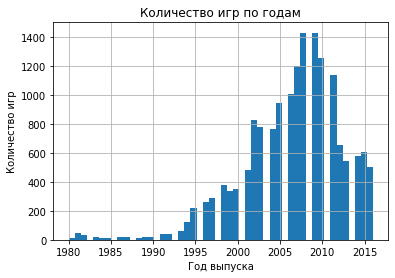

In [19]:
range_hist = [(1980, 2016)]
def func_hist (col, title, xname, yname):
    for elem in range_hist:
        x, y = elem
        games[col].hist(bins=50, range = (x, y))
        plt.title(title)
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
func_hist('year_of_release', 'Количество игр по годам', 
          'Год выпуска', 'Количество игр')

Начало выпуска игр с 1980года. Затем наблюдается небольшое снижение по выпуску игр. В период 1990-1995гг. вновь увеличение выпска игр. Самый пик приходится на 2008-2009гг., затем наблюдаем спад, возможно, переход на мобильные платформы.

**Посмотрим, как менялись продажи по платформам.**

In [21]:
platform_pivot_table = (games
     .pivot_table(index= 'platform', values='total_sales',aggfunc='sum')
     .sort_values(by = 'total_sales', ascending = False)
)
platform_pivot_table.head(10)

,total_sales
platform,
PS2,1247.28
X360,961.30
PS3,931.34
Wii,891.18
DS,802.79
PS,727.58
PS4,314.14
GBA,312.88
PSP,290.34


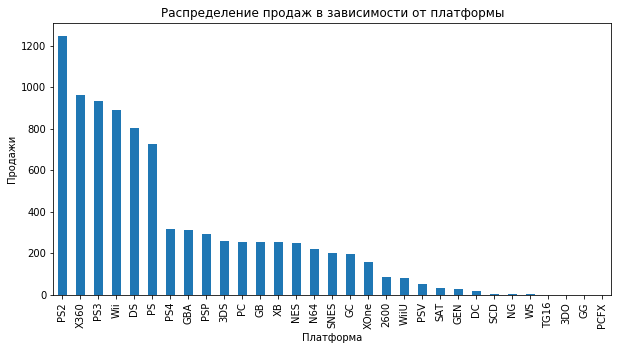

In [22]:
platform_pivot_table.plot(kind='bar', y='total_sales', figsize=(10, 5), legend=False)
plt.title('Распределение продаж в зависимости от платформы')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

**Выберем ТОП-6 платформ с наибольшими суммарными продажами и построем распределение по годам.**

In [23]:
top6_platform = platform_pivot_table.head(6)
top6_platform

,total_sales
platform,
PS2,1247.28
X360,961.30
PS3,931.34
Wii,891.18
DS,802.79
PS,727.58


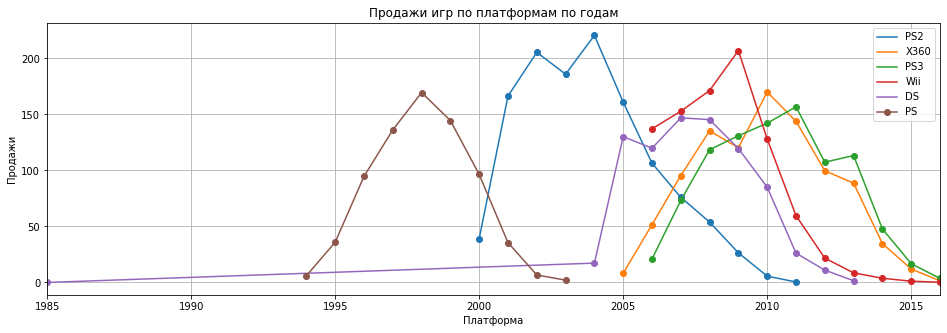

In [24]:
for platform in top6_platform.index:
    games.query('platform == @platform').groupby(['year_of_release'])['total_sales'].sum().plot(
        label = platform, style='o-', legend=True, figsize=(16,5), grid=True)
plt.title('Продажи игр по платформам по годам')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

**Возьмем данные за актуальный период (2014 - 2016гг).** Эти данные помогут построить прогноз на 2017 год.

In [27]:
games_actual = games.query('year_of_release >= 2014')

**Выберем несколько потенциально прибыльных платформ.**

In [28]:
platform_pivot_table_actual = (games_actual
     .pivot_table(index= 'platform', values='total_sales',aggfunc='sum')
     .sort_values(by = 'total_sales', ascending = False)
)
platform_pivot_table.head(10)

,total_sales
platform,
PS2,1247.28
X360,961.30
PS3,931.34
Wii,891.18
DS,802.79
PS,727.58
PS4,314.14
GBA,312.88
PSP,290.34


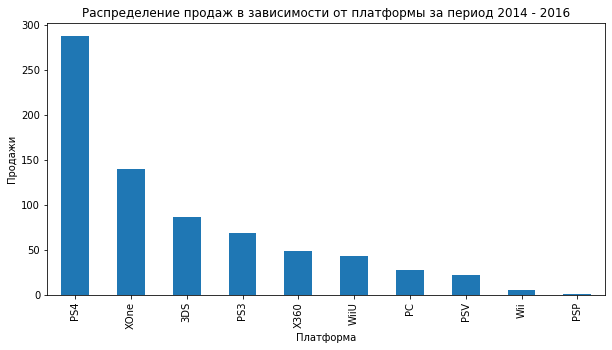

In [29]:
platform_pivot_table_actual.plot(kind='bar', y='total_sales', figsize=(10, 5), legend=False)
plt.title('Распределение продаж в зависимости от платформы за период 2014 - 2016')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

In [30]:
top7_platform_actual = platform_pivot_table_actual.head(7)
top7_platform_actual

,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05


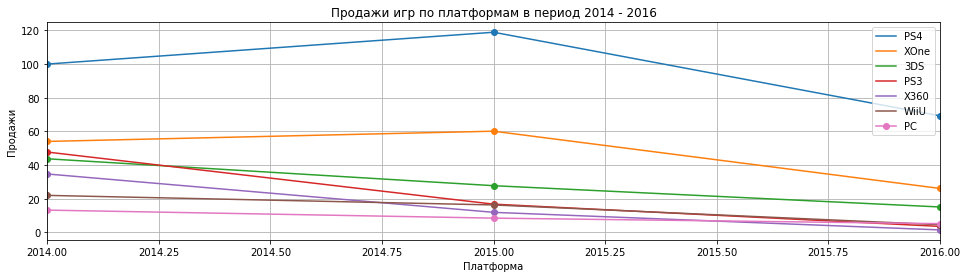

In [31]:
for platform in top7_platform_actual.index:
    games_actual.query('platform == @platform').groupby(['year_of_release'])['total_sales'].sum().plot(
        label = platform, style='o-', legend=True, figsize=(16,4), grid=True)
plt.title('Продажи игр по платформам в период 2014 - 2016')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

По данным на 2016 год лидидирующими платформами являются PS4 и XOne, а также японская консоль 3DS. Теряют свои лидирующие позиции платформы: X360, PS3 и WII (если в 2010 году эти консоли имели самые высокие глобальные продажи, то к 2016 их продажи сводятся практически к 0). Также для исследования включим также и стабильный по продажам PC.

**Построем график «ящик с усами» по глобальным продажам игр в разбивке по потенциально прибыльным платформам в 2016г.** У нас такие 4 платформы: PS4, XOne, 3DS и PC.

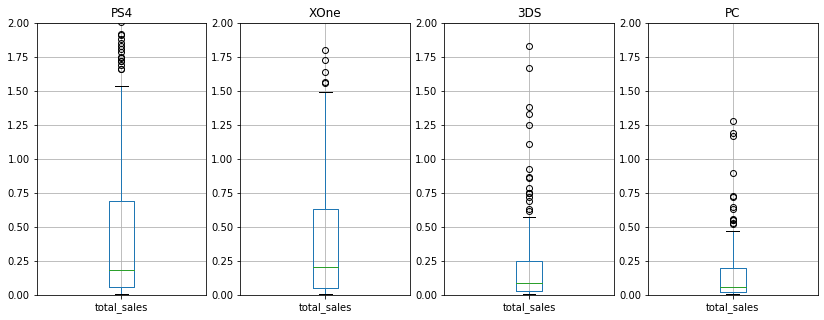

In [32]:
profitable_platforms = ['PS4', 'XOne', '3DS', 'PC']

fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (14,5))

for platform in range(len(profitable_platforms)):
    data_plot = games_actual[games_actual['platform']==profitable_platforms[platform]]['total_sales']
    data_plot.plot(kind='box', ax =ax[platform], ylim=[0, 2], title = profitable_platforms[platform], grid=True)
plt.show()

In [33]:
games_actual[games_actual['platform'] == 'PS4']['total_sales'].describe()

count    376.000000
mean       0.766356
std        1.614969
min        0.010000
25%        0.057500
50%        0.185000
75%        0.690000
max       14.630000
Name: total_sales, dtype: float64

In [34]:
games_actual[games_actual['platform'] == 'XOne']['total_sales'].describe()

count    228.000000
mean       0.615614
std        1.046513
min        0.010000
25%        0.050000
50%        0.205000
75%        0.632500
max        7.390000
Name: total_sales, dtype: float64

In [35]:
games_actual[games_actual['platform'] == '3DS']['total_sales'].describe()

count    212.000000
mean       0.408868
std        1.188368
min        0.010000
25%        0.030000
50%        0.090000
75%        0.250000
max       11.680000
Name: total_sales, dtype: float64

In [36]:
games_actual[games_actual['platform'] == 'PC']['total_sales'].describe()

count    151.000000
mean       0.179139
std        0.329359
min        0.010000
25%        0.020000
50%        0.060000
75%        0.200000
max        3.050000
Name: total_sales, dtype: float64

-  PS4
  - Минимальное значение - 0.01 млн проданных копий игр
  - Среднее значение - 0.8 млн
  - Нижний квартиль - 25 % нашей выборки находится в пределах 0.06 млн проданных копий игр
  - Медиана - 50 % выборки, разделяет выборку на 2 равные части и равна 0.2 млн
  - Верхний квартиль равен 0.7
  - Максимальное значение 14.6 млн
  
-  XOne
  - Минимальное значение - 0.01 млн проданных копий игр
  - Среднее значение - 0.6 млн
  - Нижний квартиль - 25 % нашей выборки находится в пределах 0.06 млн проданных копий игр
  - Медиана - 50 % выборки, разделяет выборку на 2 равные части и равна 0.22 млн
  - Верхний квартиль равен 0.69
  - Максимальное значение 7.4 <br>

-  3DS
  - Минимальное значение - 0.01 млн проданных копий игр
  - Среднее значение - 0.4 млн
  - Нижний квартиль - 25 % нашей выборки находится в пределах 0.03
  - Медиана - 50 % выборки, разделяет выборку на 2 равные части и равна 0.09 млн
  - Верхний квартиль равен 0.25
  - Максимальное значение 11.7 

-  PC
  - Минимальное значение - 0.01 млн проданных копий игр
  - Среднее значение - 0.18 млн
  - Нижний квартиль - 25 % нашей выборки находится в пределах 0.02
  - Медиана - 50 % выборки, разделяет выборку на 2 равные части и равна 0.06 млн
  - Верхний квартиль равен 0.2
  - Максимальное значение 3
  
Медиана по двум потенциально прибыльным платформам варьируется от 0,06 до 0,22 млн.

**Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.**

In [37]:
ps4 = games_actual.query('platform == "PS4"')
xone = games_actual.query('platform == "XOne"')
ds_3 =  games_actual.query('platform == "3DS"')                         
pc=  games_actual.query('platform == "PC"')                          
#ps4 = games_actual.query('platform == "PS4" and user_score != -1 and critic_score != -1')
#xone = games_actual.query('platform == "XOne" and user_score != -1 and critic_score != -1')

In [38]:
ps4_actual_corr = ps4.loc[:, ['user_score', 'critic_score', 'total_sales']]
ps4_actual_corr.corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.546434,-0.040132
critic_score,0.546434,1.000000,0.402661
total_sales,-0.040132,0.402661,1.000000


In [39]:
xone_actual_corr = xone.loc[:, ['user_score', 'critic_score', 'total_sales']]
xone_actual_corr.corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.440977,-0.070384
critic_score,0.440977,1.000000,0.428677
total_sales,-0.070384,0.428677,1.000000


In [40]:
ds_3_actual_corr = ds_3.loc[:, ['user_score', 'critic_score', 'total_sales']]
ds_3_actual_corr.corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.862485,0.215193
critic_score,0.862485,1.000000,0.314117
total_sales,0.215193,0.314117,1.000000


In [41]:
pc_actual_corr = pc.loc[:, ['user_score', 'critic_score', 'total_sales']]
pc_actual_corr.corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.466099,-0.071597
critic_score,0.466099,1.000000,0.174634
total_sales,-0.071597,0.174634,1.000000


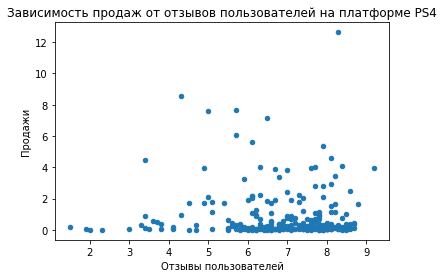

In [42]:
data_plot = ps4.plot(x = 'user_score', y = 'total_sales', kind = 'scatter')
plt.title('Зависимость продаж от отзывов пользователей на платформе PS4')
data_plot.set_xlabel('Отзывы пользователей')
data_plot.set_ylabel('Продажи')
plt.show()

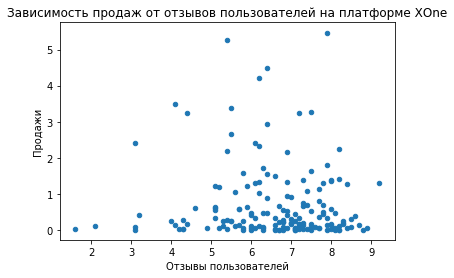

In [43]:
data_plot = xone.plot(x = 'user_score', y = 'total_sales', kind = 'scatter')
plt.title('Зависимость продаж от отзывов пользователей на платформе XOne')
data_plot.set_xlabel('Отзывы пользователей')
data_plot.set_ylabel('Продажи')
plt.show()

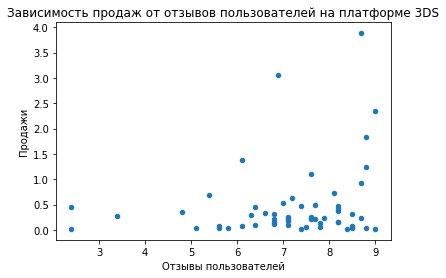

In [44]:
data_plot = ds_3.plot(x = 'user_score', y = 'total_sales', kind = 'scatter')
plt.title('Зависимость продаж от отзывов пользователей на платформе 3DS')
data_plot.set_xlabel('Отзывы пользователей')
data_plot.set_ylabel('Продажи')
plt.show()

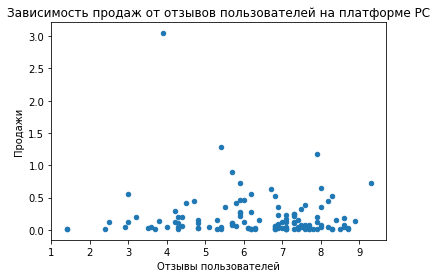

In [45]:
data_plot = pc.plot(x = 'user_score', y = 'total_sales', kind = 'scatter')
plt.title('Зависимость продаж от отзывов пользователей на платформе PC')
data_plot.set_xlabel('Отзывы пользователей')
data_plot.set_ylabel('Продажи')
plt.show()

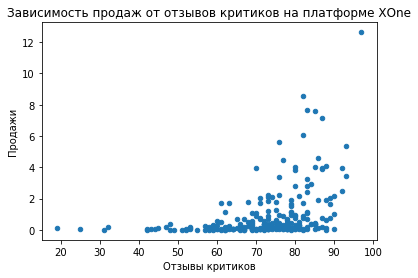

In [46]:
data_plot = ps4.plot(x = 'critic_score', y = 'total_sales', kind = 'scatter')
plt.title('Зависимость продаж от отзывов критиков на платформе XOne')
data_plot.set_xlabel('Отзывы критиков')
data_plot.set_ylabel('Продажи')
plt.show()

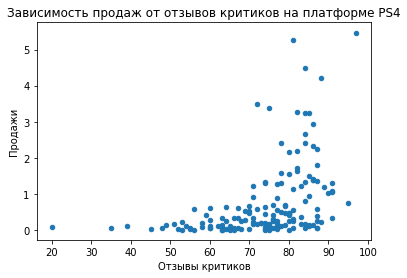

In [47]:
data_plot = xone.plot(x = 'critic_score', y = 'total_sales', kind = 'scatter')
plt.title('Зависимость продаж от отзывов критиков на платформе PS4')
data_plot.set_xlabel('Отзывы критиков')
data_plot.set_ylabel('Продажи')
plt.show()

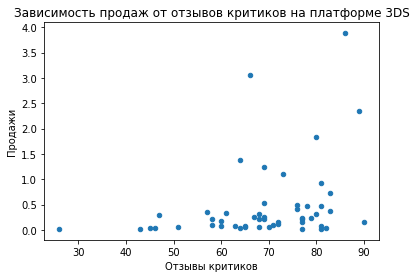

In [48]:
data_plot = ds_3.plot(x = 'critic_score', y = 'total_sales', kind = 'scatter')
plt.title('Зависимость продаж от отзывов критиков на платформе 3DS')
data_plot.set_xlabel('Отзывы критиков')
data_plot.set_ylabel('Продажи')
plt.show()

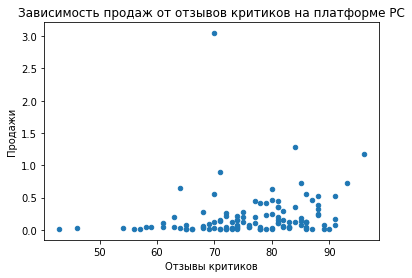

In [49]:
data_plot = pc.plot(x = 'critic_score', y = 'total_sales', kind = 'scatter')
plt.title('Зависимость продаж от отзывов критиков на платформе PC')
data_plot.set_xlabel('Отзывы критиков')
data_plot.set_ylabel('Продажи')
plt.show()

 - Зависимость между продажами и отзывами пользователей на четырех платформах: отрицательная корреляция (при возрастании значений одной переменной значения другой убывают). Можно утверждать, что на продажи пользователей слабо влияют отзывы пользователей.
 - Зависимость между продажами и отзывами критиков на четырех платформах: существует небольшая взаимосвязь 

**Соотнесем выводы с продажами игр на других платформах.**

In [50]:
games_without_popular = games_actual.query('platform != "PS4" and platform != "XOne" and \
                        platform != "3DS" and platform != "PC"')
games_without_popular.loc[:, ['user_score', 'critic_score', 'total_sales']].corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.689831,-0.055196
critic_score,0.689831,1.000000,0.293886
total_sales,-0.055196,0.293886,1.000000


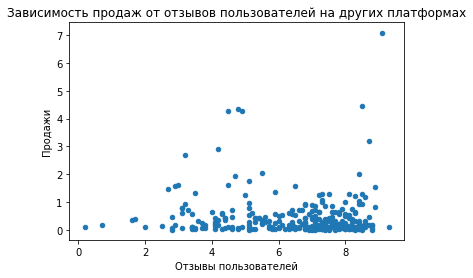

In [51]:
data_plot = games_without_popular.plot(x = 'user_score', y = 'total_sales', kind = 'scatter')
plt.title('Зависимость продаж от отзывов пользователей на других платформах')
data_plot.set_xlabel('Отзывы пользователей')
data_plot.set_ylabel('Продажи')
plt.show()

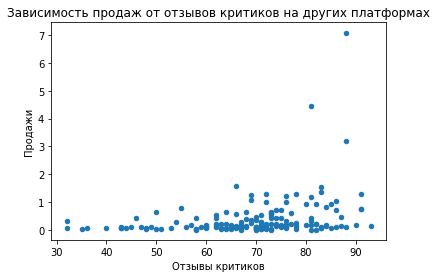

In [52]:
data_plot = games_without_popular.plot(x = 'critic_score', y = 'total_sales', kind = 'scatter')
plt.title('Зависимость продаж от отзывов критиков на других платформах')
data_plot.set_xlabel('Отзывы критиков')
data_plot.set_ylabel('Продажи')
plt.show()

 - Зависимость между продажами и отзывами пользователей на других платформах. Так же, как и на четырех популярных платформах, практически нет корреляции между продажами и отзывами пользователей
 - Зависимость между продажами и отзывами критиков на других платформах: существует небольшая взаимосвязь
 - Наблюдается взаимосвязь между отзывами критиков и пользователей

**Посмотрим на общее распределение игр по жанрам. Выделим жанры с высокими и низкими продажами.**

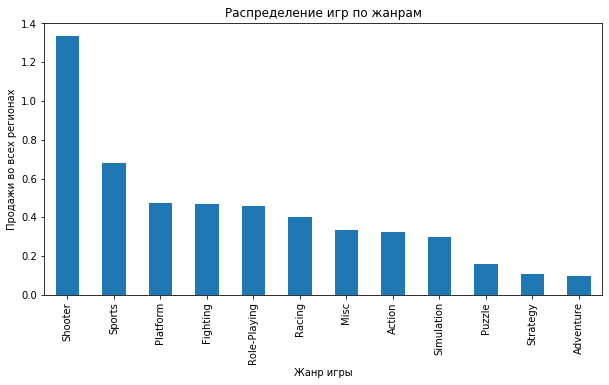

In [53]:
genre = (games_actual
     .pivot_table(index = 'genre', values='total_sales')
     .sort_values(by = 'total_sales', ascending=False)
)
genre.plot(kind='bar', y='total_sales', figsize=(10, 5), legend=False)
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанр игры')
plt.ylabel('Продажи во всех регионах')
plt.show()

Самыми продаваемыми и популярными жанрами игр являются: шутеры, платформеры и спортивные игры. <br>
Самые низкие продажи у стратегий, пазлов и игр-приключений.

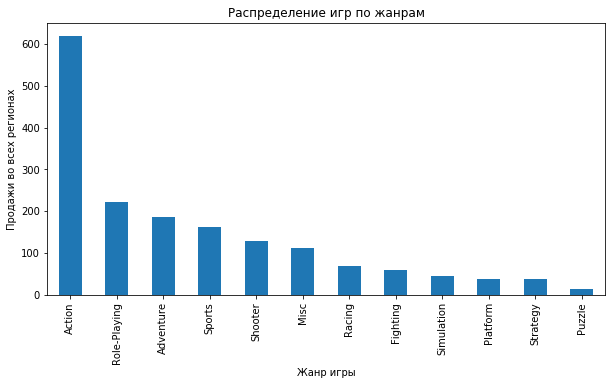

In [54]:
genre = (games_actual
     .pivot_table(index = 'genre', values='total_sales', aggfunc = 'count')
     .sort_values(by = 'total_sales', ascending=False)
)
genre.plot(kind='bar', y='total_sales', figsize=(10, 5), legend=False)
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанр игры')
plt.ylabel('Продажи во всех регионах')
plt.show()

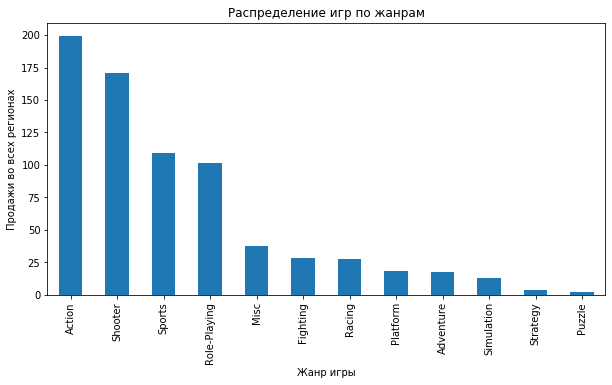

In [55]:
genre = (games_actual
     .pivot_table(index = 'genre', values='total_sales', aggfunc = 'sum')
     .sort_values(by = 'total_sales', ascending=False)
)
genre.plot(kind='bar', y='total_sales', figsize=(10, 5), legend=False)
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанр игры')
plt.ylabel('Продажи во всех регионах')
plt.show()

In [56]:
games_actual.groupby('genre')['total_sales'].agg(['sum', 'count','mean'])

,sum,count,mean
genre,,,
Action,199.36,619,0.322068
Adventure,17.55,185,0.094865
Fighting,28.22,60,0.470333
Misc,37.55,113,0.332301
Platform,18.09,38,0.476053
Puzzle,2.21,14,0.157857
Racing,27.52,69,0.398841
Role-Playing,101.44,221,0.459005
Shooter,170.94,128,1.335469


Экшен лидирует по общему количеству продаж, но среднее количество прибыли на одну игру у него меньше, чем, например, у шутеров, платформерв и спортивных игр.

### Вывод
 - Выяснили, что в наших данных начало выпуска игр с 1980года. Затем наблюдается небольшое снижение по выпуску игр. В период 1990-1995гг. вновь увеличение выпска игр. Самый пик приходится на 2008-2009гг., затем наблюдаем спад, переход на мобильные платформы.
 - В среднем за 10 лет появляются новые и исчезают старые платформы.
 - Взяли данные за **актуальный период 2014 - 2016гг**, чтобы пострость прогноз на 2017г.
 - По данным на 2016 год **лидидирующими платформами являются PS4, XOne, 3DS и PC**. Теряют свои лидирующие позиции платформы: X360, PS3 и WII (если в 2010 году эти консоли имели самые высокие глобальные продажи, то к 2016 их продажи сводятся практически к 0).
 - **Медианные значения суммарных продаж** по четырем потенциально прибыльным платформам PS4, XOne, 3DS и PC варьируется от 0,06 до 0,22 млн. **Средние значения** находятся в диапазоне: 0.4 - 0.8млн.
 - Посмотрели на **взаимосвязь данных:**
  - **Зависимость между продажами и отзывами пользователей на четырех платформах:** отрицательная корреляция. Можно утверждать, что на продажи пользователей слабо влияют отзывы пользователей.
  - **Зависимость между продажами и отзывами критиков на четырех платформах:** существует небольшая взаимосвязь
  - **Зависимость между продажами и отзывами пользователей на других платформах.** Так же, как и на двух популярных платформах, практически нет корреляции между продажами и отзывами пользователей
  - **Зависимость между продажами и отзывами критиков на других платформах:** существует небольшая взаимосвязь
  - Наблюдается **взаимосвязь между отзывами критиков и пользователей**
 - Экшен лидирует по общему количеству продаж, но среднее количество прибыли на одну игру у него меньше, чем, например, у шутеров, платформерв и спортивных игр.
 - **Самыми продаваемыми жанрами игр являются:** шутеры, платформеры и спортивные игры. Самые низкие продажи у стратегий, пазлов и приключений

### Шаг 4. Портрет пользователя каждого региона <a class="anchor" id="portrait"></a>

**Определим для пользователя каждого региона (NA, EU, JP): самые популярные платформы (топ-5).**

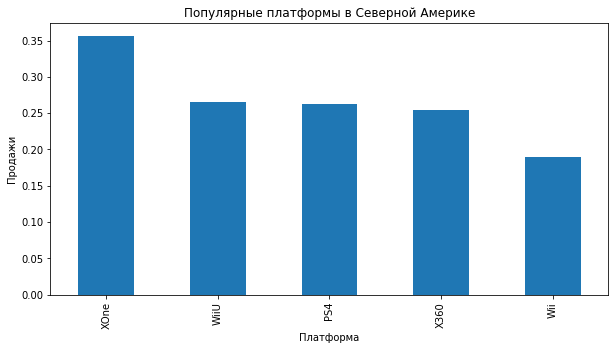

In [57]:
na_sales = (games_actual
     .pivot_table(index = 'platform', values='na_sales')
     .sort_values(by = 'na_sales', ascending=False)
     .head(5)
)
na_sales.plot(kind='bar', y='na_sales', figsize=(10, 5), legend=False)
plt.title('Популярные платформы в Северной Америке')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

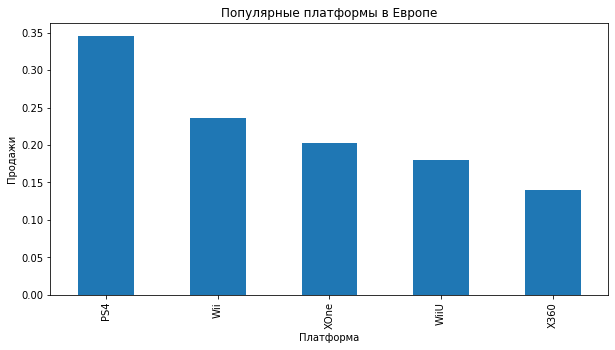

In [58]:
eu_sales = (games_actual
     .pivot_table(index = 'platform', values='eu_sales')
     .sort_values(by = 'eu_sales', ascending=False)
     .head(5)
)
eu_sales.plot(kind='bar', y='eu_sales', figsize=(10, 5), legend=False)
plt.title('Популярные платформы в Европе')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

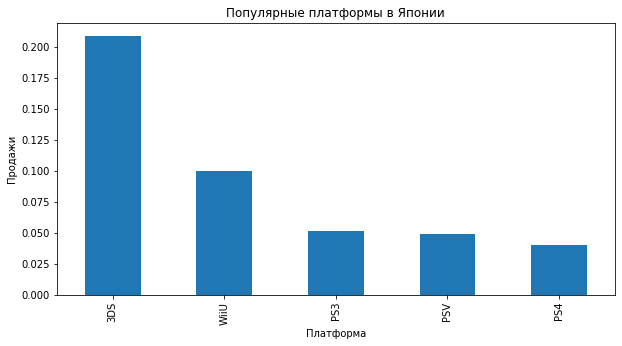

In [59]:
jp_sales = (games_actual
     .pivot_table(index = 'platform', values='jp_sales')
     .sort_values(by = 'jp_sales', ascending=False)
     .head(5)
)
jp_sales.plot(kind='bar', y='jp_sales', figsize=(10, 5), legend=False)
plt.title('Популярные платформы в Японии')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

**Самые популярные платформы в 2014 - 2016:**
 - в Северной Америке: XOne, PS4, Wii
 - в Европе: PS4, Wii, XOne
 - в Японии: 3DS, Wii, PS3 (отличается от общей картины по всему миру) 

**Определим для пользователя каждого региона (NA, EU, JP): самые популярные жанры (топ-5).**

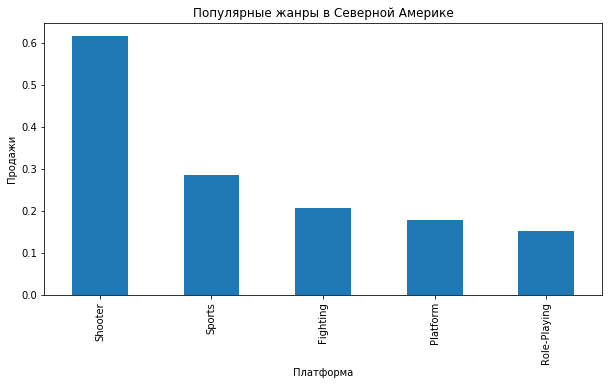

In [60]:
na_genre = (games_actual
     .pivot_table(index = 'genre', values='na_sales')
     .sort_values(by = 'na_sales', ascending=False)
     .head(5)
)
na_genre.plot(kind='bar', y='na_sales', figsize=(10, 5), legend=False)
plt.title('Популярные жанры в Северной Америке')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

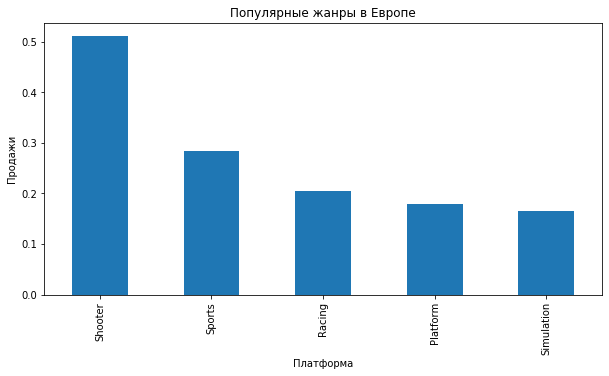

In [61]:
eu_genre = (games_actual
     .pivot_table(index = 'genre', values='eu_sales')
     .sort_values(by = 'eu_sales', ascending=False)
     .head(5)
)
eu_genre.plot(kind='bar', y='eu_sales', figsize=(10, 5), legend=False)
plt.title('Популярные жанры в Европе')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

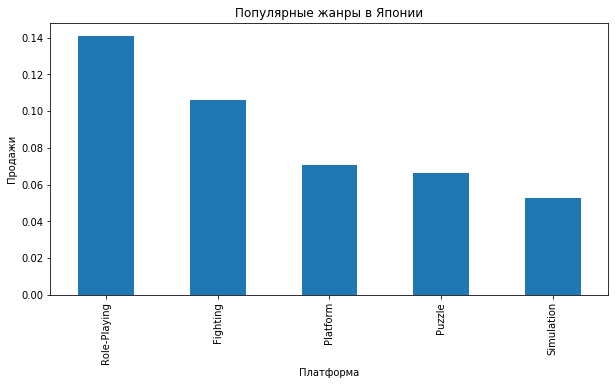

In [62]:
jp_genre = (games_actual
     .pivot_table(index = 'genre', values='jp_sales')
     .sort_values(by = 'jp_sales', ascending=False)
     .head(5)
)
jp_genre.plot(kind='bar', y='jp_sales', figsize=(10, 5), legend=False)
plt.title('Популярные жанры в Японии')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

**Самые популярные жанры игр в 2014 - 2016:**
 - в Северной Америке: шутеры, спортивные игры и файтинг
 - в Европе: шутеры, спортивные игры и гоночные игры
 - в Японии: игры по ролям, платформеры и файтинг

**Определим для пользователя каждого региона (NA, EU, JP): влияет ли рейтинг ESRB на продажи в отдельном регионе.**

| Описание рейтинга |  | 
| :- | -: |
| «EC» («Early childhood») | Для детей младшего возраста | 
| «E» («Everyone») | Для всех | 
| «E10+» («Everyone 10 and older») | Для всех от 10 лет и старше | 
| «T» («Teen») | Подросткам | 
| «M» («Mature»)| Для взрослых | 
| «RP» («Rating Pending»)  | Рейтинг ожидается | 

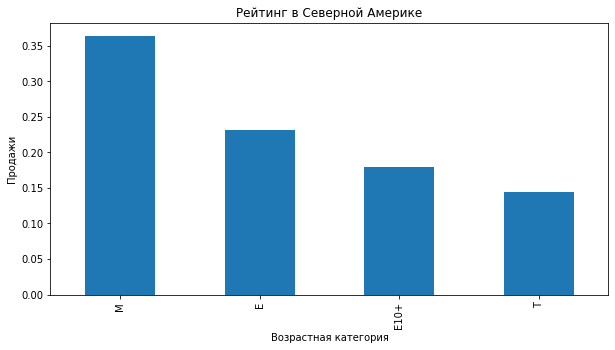

In [63]:
na_rating = (games_actual
     .pivot_table(index = 'rating', values='na_sales')
     .sort_values(by = 'na_sales', ascending=False)
     .head(5)
)
na_rating.plot(kind='bar', y='na_sales', figsize=(10, 5), legend=False)
plt.title('Рейтинг в Северной Америке')
plt.xlabel('Возрастная категория')
plt.ylabel('Продажи')
plt.show()

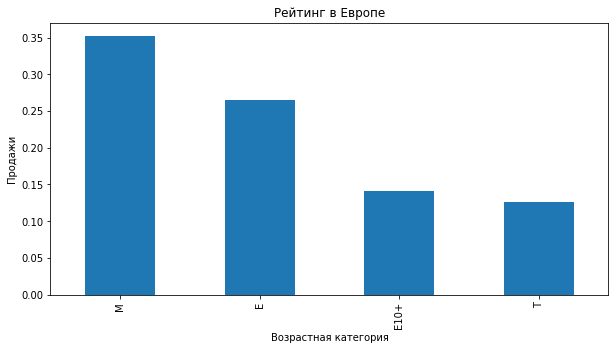

In [64]:
eu_rating = (games_actual
     .pivot_table(index = 'rating', values='eu_sales')
     .sort_values(by = 'eu_sales', ascending=False)
     .head(5)
)
eu_rating.plot(kind='bar', y='eu_sales', figsize=(10, 5), legend=False)
plt.title('Рейтинг в Европе')
plt.xlabel('Возрастная категория')
plt.ylabel('Продажи')
plt.show()

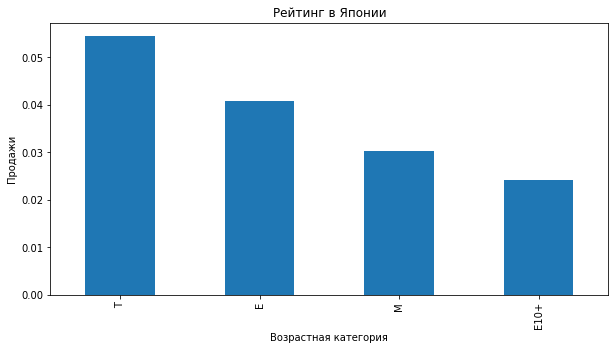

In [65]:
jp_rating = (games_actual
     .pivot_table(index = 'rating', values='jp_sales')
     .sort_values(by = 'jp_sales', ascending=False)
     .head(5)
)
jp_rating.plot(kind='bar', y='jp_sales', figsize=(10, 5), legend=False)
plt.title('Рейтинг в Японии')
plt.xlabel('Возрастная категория')
plt.ylabel('Продажи')
plt.show()

**Влияет ли рейтинг ESRB на продажи в отдельном регионе в 2014 - 2016:**
 - в Северной Америке: лучше продаются игры для взрослых и для всех (от 6 лет и старше)
 - в Европе: лучше продаются игры для взрослых и для всех (от 6 лет и старше)
 - в Японии: для всех (от 6 лет и старше) и для подростков

### Вывод
**Самые популярные платформы в 2014 - 2016:**
 - в Северной Америке: XOne, PS4, Wii
 - в Европе: PS4, Wii, XOne
 - в Японии: 3DS, Wii, PS3 (отличается от общей картины по всему миру) 
 
**Самые популярные жанры игр в 2014 - 2016:**
 - в Северной Америке: шутеры, спортивные игры и файтинг
 - в Европе: шутеры, спортивные игры и гоночные игры
 - в Японии: игры по ролям, платформеры и файтинг
 
**Влияет ли рейтинг ESRB на продажи в отдельном регионе в 2014 - 2016:**
 - в Северной Америке: лучше продаются игры для взрослых и для всех (от 6 лет и старше)
 - в Европе: лучше продаются игры для взрослых и для всех (от 6 лет и старше)
 - в Японии: для всех (от 6 лет и старше) и для подростков

### Шаг 5. Проверка гипотез <a class="anchor" id="hypotheses"></a>

**Гипотеза. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**  <br>
H0: Средние пользовательские рейтинги платформ Xbox One и PC **одинаковые.** <br>
H1: Средние пользовательские рейтинги платформ Xbox One и PC **различаются.** 

In [66]:
xbox_one = games_actual.loc[games_actual['platform'] == 'XOne']
pc = games_actual.loc[games_actual['platform'] == 'PC']

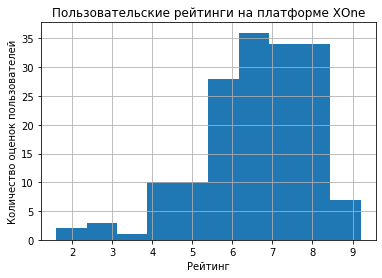

In [67]:
xbox_one['user_score'].hist()
plt.title('Пользовательские рейтинги на платформе XOne')
plt.xlabel('Рейтинг')
plt.ylabel('Количество оценок пользователей')
plt.show()

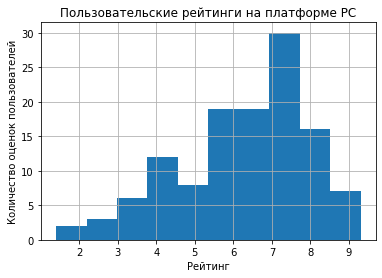

In [68]:
pc['user_score'].hist()
plt.title('Пользовательские рейтинги на платформе PC')
plt.xlabel('Рейтинг')
plt.ylabel('Количество оценок пользователей')
plt.show()

In [69]:
alpha = .05 # критический уровень статистической значимости 

results = st.ttest_ind(
    xbox_one['user_score'], 
    pc['user_score'],
    equal_var=False, # считаем, что дисперсии наших выборок различны
    nan_policy='omit') # необходимо установить параметр игнорирования пропущенных значений пользовательских оценок

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668985
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Гипотеза. Средние пользовательские рейтинги жанров Action (экшен-игры) и Sports (спортивные соревнования) разные.** <br>
H0: Средние пользовательские рейтинги жанров Action (экшен-игры) и Sports (спортивные соревнования) **одинаковые.** <br>
Н1: Средние пользовательские рейтинги жанров Action (экшен-игры) и Sports (спортивные соревнования) **разные.**

In [70]:
action = games_actual.loc[games_actual['genre'] == 'Action']
sports = games_actual.loc[games_actual['genre'] == 'Sports']

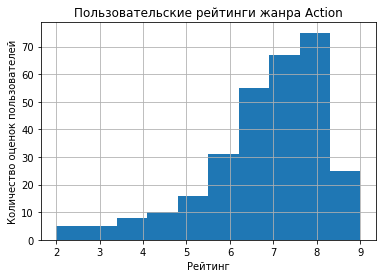

In [71]:
action['user_score'].hist()
plt.title('Пользовательские рейтинги жанра Action')
plt.xlabel('Рейтинг')
plt.ylabel('Количество оценок пользователей')
plt.show()

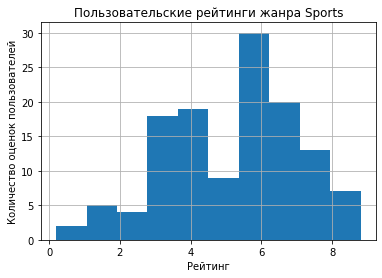

In [72]:
sports['user_score'].hist()
plt.title('Пользовательские рейтинги жанра Sports')
plt.xlabel('Рейтинг')
plt.ylabel('Количество оценок пользователей')
plt.show()

In [73]:
alpha = .05 # критический уровень статистической значимости 

results = st.ttest_ind(
    action['user_score'], 
    sports['user_score'],
    equal_var=False, # считаем, что дисперсии наших выборок различны
    nan_policy='omit') # необходимо установить параметр игнорирования пропущенных значений пользовательских оценок

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644845e-14
Отвергаем нулевую гипотезу


Практически нулевая вероятность говорит о том, что средние пользовательские рейтинги жанров Action и Sport имеют статистически значимые различия.

### Шаг 6. Общий вывод  <a class="anchor" id="conclusion"></a>

В результате работы были выявлены следующие инсайты.

1. В среднем за 10 лет появляются новые и исчезают старые платформы.
2. Взяв данные за актуальный период (2014 - 2016), выявили лидирующие платформы PS4, XOne, 3DS и PC
3. Посмотрели на **взаимосвязь данных:**
 - **Зависимость между продажами и отзывами пользователей.** практически нет корреляции между продажами и отзывами пользователей
 - **Зависимость между продажами и отзывами критиков на других платформах:** существует небольшая взаимосвязь
 - Наблюдается **взаимосвязь между отзывами критиков и пользователей**
4. Жанр Экшен лидирует по общему количеству продаж, но среднее количество прибыли на одну игру у него меньше, чем, например, у шутеров, платформерв и спортивных игр.
5. Самыми продаваемыми и популярными жанрами игр являются: шутеры, платформеры и спортивные игры. Самые низкие продажи у стратегий, пазлов и приключений
6. С целью планирования рекламной кампании составили **портрет пользователя каждого региона.**
 - **Северная Америка.** Популярные платформы XOne, PS4, Wii; Популярные жанры: шутеры, спортивные игры и файтинг. Лучше продаются игры для взрослых и для всей семьи (от 6 лет и старше).
 - **Европа.** Популярные платформы PS4, Wii, XOne; Популярные жанры: шутеры, спортивные игры и гоночные игры. Лучше продаются игры для взрослых и для всей семьи (от 6 лет и старше).
 - **Япония.** Популярные платформы 3DS, Wii, PS3; Популярные жанры: игры по ролям, платформеры и файтинг. Лучше продаются игры для всей семьи (от 6 лет и старше) и для подростков.

**Проверка гипотез.** <br>
Гипотеза. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Не получилось отвергнуть нулевую гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. <br>
Гипотеза. Средние пользовательские рейтинги жанров Action (экшен-игры) и Sports (спортивные соревнования) разные. Практически нулевая вероятность говорит о том, что средние пользовательские рейтинги жанров Action и Sport имеют статистически значимые различия.